# Interpretable Modelling of Credit Risk

As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

# uuploading columns

metadata = pd.read_excel(
    "https://github.com/nickeubank/MIDS_Data/raw/master/PAKDD%202010/PAKDD2010_VariablesList.XLS"
)

columns = metadata["Var_Title"]

columns[columns == "EDUCATION_LEVEL"]

columns[43] = "EDUCATION_LEVEL_MATE"

# load the PAKDD2010 dataset
data = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/PAKDD%202010/PAKDD2010_Modeling_Data.txt",
    header=None,
    delimiter="\t",
    encoding="latin1",
    names=columns,
)

### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [2]:
missing_values = data.isnull().sum()

missing_values[missing_values > 0]

variables_w_nan = list(
    missing_values[missing_values > 0].sort_values(ascending=False).index
)
variables_w_nan.remove("OCCUPATION_TYPE")
variables_w_nan.remove("MONTHS_IN_RESIDENCE")
variables_w_nan.remove("RESIDENCE_TYPE")
variables_w_nan = variables_w_nan[:6]

In [3]:
# variables to drop
to_drop = variables_w_nan

data.drop(columns=to_drop, inplace=True)

### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [4]:
variables = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
]

data[variables].describe()

,QUANT_DEPENDANTS,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE
count,50000.000000,50000.000000,46223.000000,50000.000000,50000.000000,50000.00000,50000.00000,42687.000000,48651.000000
mean,0.650520,0.336140,9.727149,886.678437,0.357840,43.24852,2.14840,2.484316,1.252225
std,1.193655,0.472392,10.668841,7846.959327,0.479953,14.98905,1.32285,1.532261,0.867833
min,0.000000,0.000000,0.000000,60.000000,0.000000,6.00000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,360.000000,0.000000,31.00000,1.00000,1.000000,1.000000
50%,0.000000,0.000000,6.000000,500.000000,0.000000,41.00000,2.00000,2.000000,1.000000
75%,1.000000,1.000000,15.000000,800.000000,1.000000,53.00000,2.00000,4.000000,1.000000
max,53.000000,1.000000,228.000000,959000.000000,2.000000,106.00000,7.00000,5.000000,5.000000


In [5]:
print(data.shape)

np.sum(data["QUANT_DEPENDANTS"] > 20)

(50000, 49)


1

```Two variables arose concerns, first QUANT_DEPENDANTS, with a grat outlier with 53 dependants and income, a variable highly right skewed. Thus a transformation to logs is necessary in both cases.```

In [6]:
data["log_quant_dependants"] = np.log(data["QUANT_DEPENDANTS"] + 1e-10)
variables.append("log_quant_dependants")
variables.remove("QUANT_DEPENDANTS")

In [7]:
data["log_personal_monthly_income"] = np.log(data["PERSONAL_MONTHLY_INCOME"] + 1e-10)
variables.append("log_personal_monthly_income")
variables.remove("PERSONAL_MONTHLY_INCOME")

In [8]:
variables

['QUANT_CARS',
 'MONTHS_IN_RESIDENCE',
 'QUANT_BANKING_ACCOUNTS',
 'AGE',
 'SEX',
 'MARITAL_STATUS',
 'OCCUPATION_TYPE',
 'RESIDENCE_TYPE',
 'RESIDENCIAL_STATE',
 'RESIDENCIAL_CITY',
 'RESIDENCIAL_BOROUGH',
 'RESIDENCIAL_ZIP_3',
 'log_quant_dependants',
 'log_personal_monthly_income']

In [9]:
data.head(2)

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1,log_quant_dependants,log_personal_monthly_income
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,1,N,32,595,595,1,1.000000e-10,6.802395
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,1,N,34,230,230,1,-2.302585e+01,6.620073


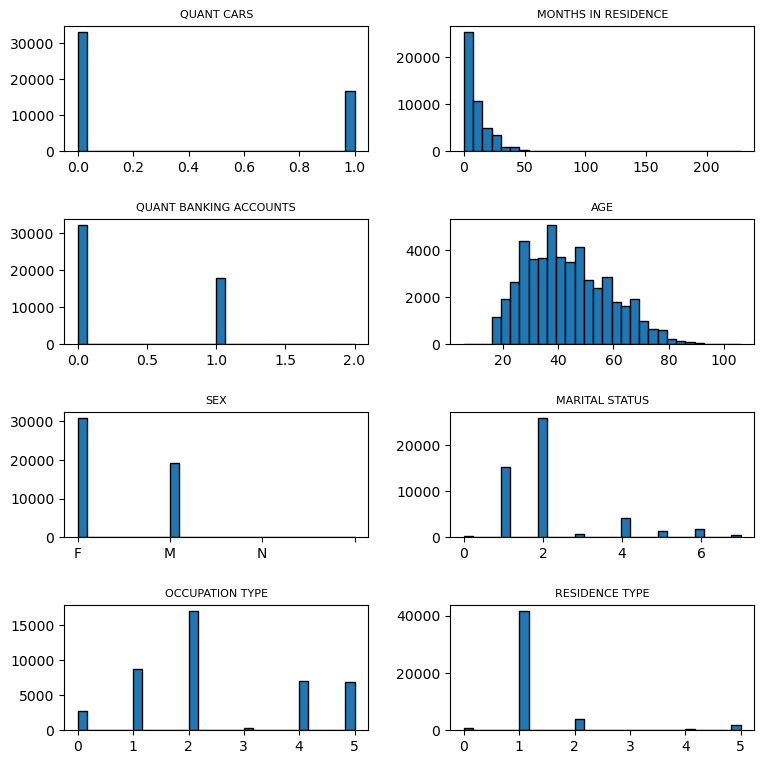

In [10]:
import matplotlib.pyplot as plt

col = 2
row = 4

fig, axs = plt.subplots(row, col, figsize=(8, 8))
columns = 2  # number of columns per row

for i in range(4):
    for j in range(4):
        index = i * columns + j  # calculate the index
        if index >= len(variables):  # check if index is out of bounds
            break
        if variables[index] not in data.keys():  # check if the variable is a valid key
            print(f"Variable {variables[index]} is not a valid key")
            continue
        try:
            if variables[index] in ["RESIDENCIAL_CITY", "RESIDENCIAL_BOROUGH"]:
                pass
            else:
                axs[i, j].hist(
                    data[variables[index]].dropna(), bins=30, edgecolor="black"
                )
                axs[i, j].set_title(f"{variables[index]}".replace("_", " "), fontsize=8)
        except:
            pass

plt.tight_layout(pad=2.0)  # adjust spacing between subplots
plt.show()

In [11]:
import re
import unicodedata
import pandas as pd

# Load city names from the CSV file
cities_df = pd.read_csv("data/brasilian_cities.csv")

# Extract city names from the DataFrame
cities_text = cities_df["City"]


# Function to remove accents and special characters from text
def clean_text(text):
    # Remove special characters
    text = text.replace("*", "")
    # Remove accents
    text = "".join(
        c for c in unicodedata.normalize("NFD", text) if not unicodedata.combining(c)
    )
    return text.strip().lower()


# Clean the city names
clean_cities = [clean_text(city) for city in cities_text]

# Print the clean list of cities
print(clean_cities[:3])

['sao paulo', 'rio de janeiro', 'brasilia']


In [12]:
data["RESIDENCIAL_CITY"] = data["RESIDENCIAL_CITY"].apply(lambda x: x.lower())
len(np.unique(data["RESIDENCIAL_CITY"]))

2483

In [13]:
import pandas as pd
from fuzzywuzzy import process

# Assuming you have a DataFrame called data with a column RESIDENCIAL_CITY
# and you want to create a new column called "closest_city"

# Create a dictionary of city names as keys and their normalized counterparts as values
city_mapping = {city: city.lower() for city in clean_cities}


# Function to find the closest city from clean_cities for a given city_name
def find_closest_city(city_name):
    # Use fuzzywuzzy's process.extractOne to find the closest match
    closest_match = process.extractOne(city_name.lower(), city_mapping.keys())
    # Return the original city name (not the normalized one)
    return closest_match[0] if closest_match else None


# Apply the find_closest_city function to each element in the RESIDENCIAL_CITY column
data["closest_city"] = data["RESIDENCIAL_CITY"].apply(find_closest_city)

# Now, you have a new column called 'closest_city' in your DataFrame,
# which contains the closest matching city name from clean_cities

```There were a lot of cities that had typos on their names, what we did in the code just to show what this data would look like is assign the city we know is well written got from Wikipedia and then plot them. On wikipedia we found 319 cities instead of 2,483 unique values.```

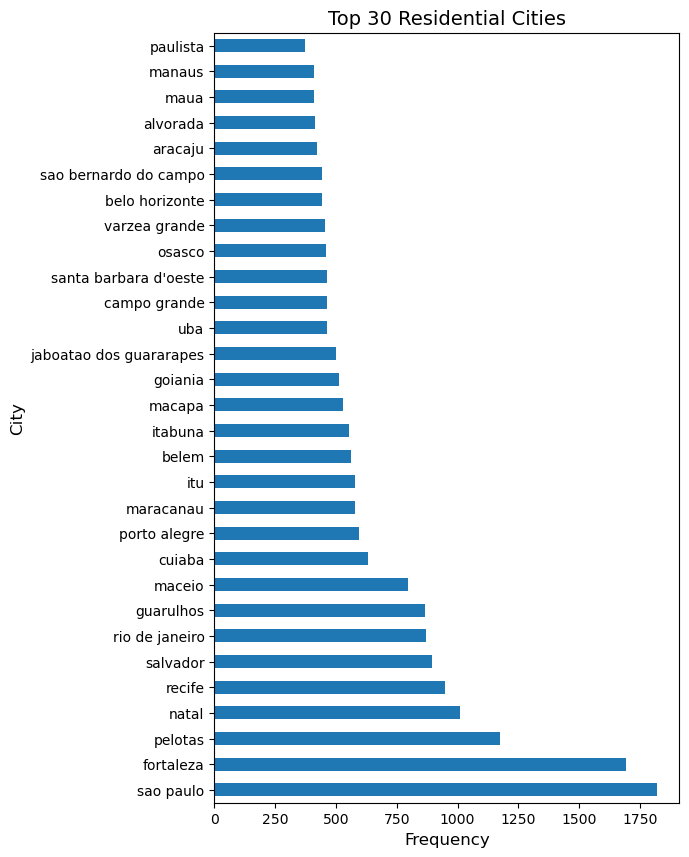

In [14]:
import matplotlib.pyplot as plt

# Assuming data["closest_city"] contains the closest city names

# Select the top 30 closest cities
top_30_cities = data["closest_city"].value_counts().nlargest(30)

# Plotting
plt.figure(figsize=(6, 10))  # Adjust the figure size as needed
top_30_cities.plot(kind="barh")
plt.title("Top 30 Residential Cities", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("City", fontsize=12)
plt.show()

In [15]:
len(np.unique(data["RESIDENCIAL_BOROUGH"].apply(lambda x: x.lower())))

11815

```We identified the same problem in Boroughs than in cities, mispelled words filled by people, a similar analysis as the one done for cities could be made but it's out of the scope of this assigment```

### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

```The problem was exposed in the question 3```

In [16]:
# Identify columns containing "RESIDENCIAL_" in their name
residential_columns = data.filter(regex="^RESIDENCIAL_").columns

# Drop the identified columns
data = data.drop(columns=residential_columns)

## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

In [17]:
variables = [
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "log_quant_dependants",
    "log_personal_monthly_income",
]

In [18]:
def fix_sex(x):
    if x == " " or x == "N":
        x = np.nan
    return x


data["SEX"] = data["SEX"].apply(lambda x: fix_sex(x))

In [19]:
variables_to_keep = variables + ["TARGET_LABEL_BAD=1"]
X = data[variables_to_keep]
X = pd.get_dummies(X, columns=["SEX"], drop_first=True)
X["SEX_M"] = X["SEX_M"].apply(lambda x: int(x))
X.head(3)

,QUANT_CARS,MONTHS_IN_RESIDENCE,QUANT_BANKING_ACCOUNTS,AGE,MARITAL_STATUS,OCCUPATION_TYPE,log_quant_dependants,log_personal_monthly_income,TARGET_LABEL_BAD=1,SEX_M
0,0,15.0,0,32,6,4.0,1.000000e-10,6.802395,1,0
1,0,1.0,0,34,2,4.0,-2.302585e+01,6.620073,1,0
2,0,NaN,0,27,2,NaN,-2.302585e+01,6.214608,0,0


In [20]:
X.isna().sum()

QUANT_CARS                        0
MONTHS_IN_RESIDENCE            3777
QUANT_BANKING_ACCOUNTS            0
AGE                               0
MARITAL_STATUS                    0
OCCUPATION_TYPE                7313
log_quant_dependants              0
log_personal_monthly_income       0
TARGET_LABEL_BAD=1                0
SEX_M                             0
dtype: int64

In [21]:
X.dropna(inplace=True)

In [22]:
from sklearn.model_selection import train_test_split

from pygam import LogisticGAM, s, f

y = np.array(X["TARGET_LABEL_BAD=1"])
print(X.columns)
X = np.array(X.drop(columns="TARGET_LABEL_BAD=1"))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Index(['QUANT_CARS', 'MONTHS_IN_RESIDENCE', 'QUANT_BANKING_ACCOUNTS', 'AGE',
       'MARITAL_STATUS', 'OCCUPATION_TYPE', 'log_quant_dependants',
       'log_personal_monthly_income', 'TARGET_LABEL_BAD=1', 'SEX_M'],
      dtype='object')


In [23]:
gam = LogisticGAM(
    s(0)  # quant cars
    + s(1)  # month of residence
    + s(2)  # quant banking accounts
    + s(3)  # age
    + f(4)  # Marital status
    + f(5)  # occupation type
    + s(6)  # log dependants
    + s(7)  # log income
    + f(8)  # sex_m
).gridsearch(X_train, y_train)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:12 ETA:   0:02:07
 18% (2 of 11) |####                     | Elapsed Time: 0:00:21 ETA:   0:01:34
 27% (3 of 11) |######                   | Elapsed Time: 0:00:29 ETA:   0:01:17
 36% (4 of 11) |#########                | Elapsed Time: 0:00:37 ETA:   0:01:04
 45% (5 of 11) |###########              | Elapsed Time: 0:00:44 ETA:   0:00:53
 54% (6 of 11) |#############            | Elapsed Time: 0:00:51 ETA:   0:00:42
 63% (7 of 11) |###############          | Elapsed Time: 0:00:56 ETA:   0:00:32
 72% (8 of 11) |##################       | Elapsed Time: 0:01:03 ETA:   0:00:23
 81% (9 of 11) |####################     | Elapsed Time: 0:01:10 ETA:   0:00:15
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:17 ETA:   0:00:07
100% (11 of 11) |########################| Elapsed Time: 0:01:25 Time:  0:01:25


### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

In [24]:
from sklearn.metrics import confusion_matrix

y_pred = gam.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)

pd.DataFrame(
    conf_mat,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)

,Predicted Negative,Predicted Positive
Actual Negative,6051,2
Actual Positive,2097,3


In [25]:
false_omission_rate = conf_mat[1][0] / conf_mat[:, 0].sum()

print(f"The false omission rate is: {false_omission_rate:.4f}")

The false omission rate is: 0.2574


### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

In [34]:
def false_omission(threshold):
    probs = gam.predict_proba(X_test)
    y_pred = list(map(int, gam.predict_proba(X_test) > threshold))
    conf_mat = confusion_matrix(y_test, y_pred)
    false_omission_rate = conf_mat[1][0] / conf_mat[:, 0].sum()
    return false_omission_rate, conf_mat[0][0]


for i in np.arange(0.12, 0.15, 0.005).tolist():
    a, b = false_omission(i)
    print(
        f"With a threshold of {i:.6f} the False Omission rate is {a:.4f} and the TN is {b:,.0f}"
    )

With a threshold of 0.120000 the False Omission rate is nan and the TN is 0
With a threshold of 0.125000 the False Omission rate is 0.0000 and the TN is 1
With a threshold of 0.130000 the False Omission rate is 0.0000 and the TN is 2
With a threshold of 0.135000 the False Omission rate is 0.0000 and the TN is 10
With a threshold of 0.140000 the False Omission rate is 0.1176 and the TN is 15
With a threshold of 0.145000 the False Omission rate is 0.1892 and the TN is 30


In [37]:
probs = gam.predict_proba(X_test)
y_pred = list(map(int, gam.predict_proba(X_test) > 0.135))
conf_mat = confusion_matrix(y_test, y_pred)

pd.DataFrame(
    conf_mat,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)

,Predicted Negative,Predicted Positive
Actual Negative,10,6043
Actual Positive,0,2100


### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

In [35]:
def false_omission(threshold):
    probs = gam.predict_proba(X_test)
    y_pred = list(map(int, gam.predict_proba(X_test) > threshold))
    conf_mat = confusion_matrix(y_test, y_pred)
    false_omission_rate = conf_mat[1][0] / conf_mat[:, 0].sum()
    return false_omission_rate, conf_mat[0][0]


for i in np.arange(0.2304, 0.2306, 0.00005).tolist():
    a, b = false_omission(i)
    print(
        f"With a threshold of {i:.6f} the False Omission rate is {a:.4f} and the TN is {b:,.0f}"
    )

With a threshold of 0.230400 the False Omission rate is 0.1893 and the TN is 2,163
With a threshold of 0.230450 the False Omission rate is 0.1892 and the TN is 2,164
With a threshold of 0.230500 the False Omission rate is 0.1892 and the TN is 2,164
With a threshold of 0.230550 the False Omission rate is 0.1897 and the TN is 2,166
With a threshold of 0.230600 the False Omission rate is 0.1903 and the TN is 2,166


```2,166 are the True Negatives that will be ble to enroll```

## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

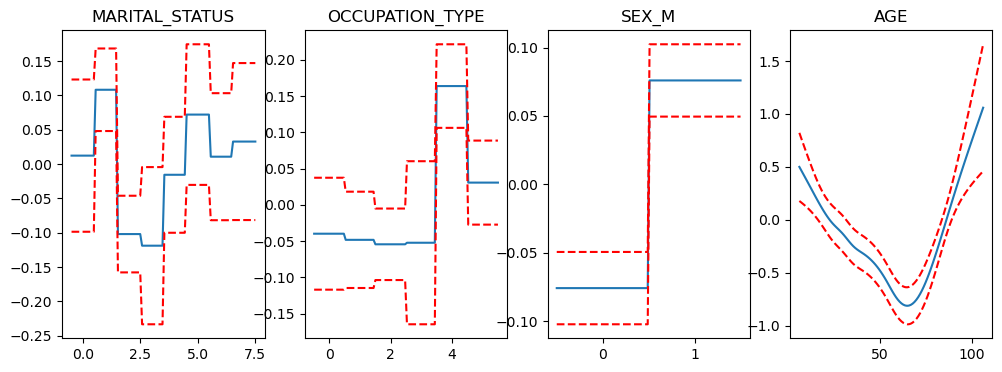

In [28]:
# Index(['QUANT_CARS', 'MONTHS_IN_RESIDENCE', 'QUANT_BANKING_ACCOUNTS', 'AGE',
#        'MARITAL_STATUS', 'OCCUPATION_TYPE', 'log_quant_dependants',
#        'log_personal_monthly_income', 'TARGET_LABEL_BAD=1', 'SEX_M'],

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
titles = ["MARITAL_STATUS", "OCCUPATION_TYPE", "SEX_M", "AGE"]
terms = [4, 5, 8, 3]

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=terms[i])
    pdep, confi = gam.partial_dependence(term=terms[i], width=0.95)

    ax.plot(XX[:, terms[i]], pdep)
    ax.plot(XX[:, terms[i]], confi, c="r", ls="--")
    ax.set_title(titles[i])

### Exercise 10

How does the partial correlation with respect to age look?

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

### Exercise 15

Add an interaction term between age and personal income.

### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```